In [41]:
import pandas as pd

In [42]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
train = pd.read_csv("train.csv")
train.head()

,id,sentiment,tweet
0,14045,Negative,"#bihday, pep! we all love you.."
1,22431,Positive,plz sign #japan #bullying #tweet4taiji
2,11924,Negative,@user whatever you decide to do make sure it ...
3,21714,Negative,that's a good dog
4,25726,Negative,#roses gorilla simulator: you need to do to ...


In [44]:
train["sentiment"].value_counts()

sentiment
Negative    5217
Positive     383
Name: count, dtype: int64

In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600 entries, 0 to 5599
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         5600 non-null   int64 
 1   sentiment  5600 non-null   object
 2   tweet      5600 non-null   object
dtypes: int64(1), object(2)
memory usage: 131.4+ KB


In [46]:
test = pd.read_csv("test.csv")

In [47]:
test["sentiment"].value_counts()

sentiment
Negative    1302
Positive      98
Name: count, dtype: int64

In [48]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords

In [49]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic characters (excluding spaces)
    words = text.split()  # Tokenization
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return " ".join(words)

train["clean_tweet"] = train["tweet"].apply(preprocess_text)
train.head()

,id,sentiment,tweet,clean_tweet
0,14045,Negative,"#bihday, pep! we all love you..",bihday pep love
1,22431,Positive,plz sign #japan #bullying #tweet4taiji,plz sign japan bullying tweettaiji
2,11924,Negative,@user whatever you decide to do make sure it ...,user whatever decide make sure makes
3,21714,Negative,that's a good dog,thats good dog
4,25726,Negative,#roses gorilla simulator: you need to do to ...,roses gorilla simulator need adapt environment...


In [50]:
test["clean_tweet"] = test["tweet"].apply(preprocess_text)

test.head()

,id,sentiment,tweet,clean_tweet
0,19818,Negative,yes!! #crashbandicoot remake for #ps4 ðµðµ...,yes crashbandicoot remake ps made day woo want...
1,14921,Positive,nothing would be more dangerous than to give #...,nothing would dangerous give putinschoice impr...
2,52,Negative,for her #bihday we got her a #nose #job @user ...,bihday got nose job user bihday petunia love
3,11017,Negative,a true inspiration #raringtogo,true inspiration raringtogo
4,28759,Negative,â #us may ppi: inflationary pressures slowl...,us may ppi inflationary pressures slowly build...


In [51]:
glove_path = "glove.6B.200d.txt"  # Path to GloVe file
embedding_dim = 200

# Collect all unique words from train and test sets
all_words = set()
for tweet in train["clean_tweet"].tolist() + test["clean_tweet"].tolist():
    all_words.update(tweet.split())

# Load only required GloVe word vectors
glove_embeddings = {}

with open(glove_path, "r", encoding="utf-8") as file:
    for line in file:
        values = line.split()
        word = values[0]
        if word in all_words:  # Only store relevant words
            vector = np.asarray(values[1:], dtype="float32")
            glove_embeddings[word] = vector

print(f"Loaded {len(glove_embeddings)} word vectors.")


Loaded 9026 word vectors.


In [52]:
def get_tweet_embedding(tweet, max_len=50):
    words = tweet.split()
    valid_embeddings = [glove_embeddings.get(word, np.zeros(embedding_dim)) for word in words]

    # Pad or truncate to max_len
    if len(valid_embeddings) < max_len:
        valid_embeddings += [np.zeros(embedding_dim)] * (max_len - len(valid_embeddings))  # Pad
    else:
        valid_embeddings = valid_embeddings[:max_len]  # Truncate
    
    return np.array(valid_embeddings)

In [53]:
import swifter

X_train = np.array(train["clean_tweet"].swifter.apply(get_tweet_embedding).tolist())

Pandas Apply:   0%|          | 0/5600 [00:00<?, ?it/s]

In [54]:
y_train = train["sentiment"].map({"Positive": 1, "Negative": 0})  # Adjust based on dataset labels

In [55]:
X_test_data = np.array(test["clean_tweet"].swifter.apply(get_tweet_embedding).tolist())

y_test_data = test["sentiment"].map({"Positive":1, "Negative": 0})

Pandas Apply:   0%|          | 0/1400 [00:00<?, ?it/s]

In [56]:
X_test_data = np.array(X_test_data, dtype=np.float32)
y_test_data = np.array(y_test_data)

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [58]:
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train, y_train, test_size=0.2, random_state=41)

In [59]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [60]:
model1 = Sequential([
    SimpleRNN(25, input_shape=(1, 200), return_sequences=False),  # 1 hidden layer
    Dense(1, activation='sigmoid')  # Binary output (positive/negative)
])

# Compile model
model1.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


In [61]:
X_train1 = np.array(X_train1, dtype=np.float32)
X_val1 = np.array(X_val1, dtype=np.float32)
y_train1 = np.array(y_train1)
y_val1 = np.array(y_val1)

In [62]:
X_train1.shape

(4480, 50, 200)

In [63]:
model1.fit(X_train1, y_train1, epochs=5, batch_size = 10, validation_data=(X_val1, y_val1))

Epoch 1/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9105 - loss: 0.3111 - val_accuracy: 0.9375 - val_loss: 0.2345
Epoch 2/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9286 - loss: 0.2592 - val_accuracy: 0.9375 - val_loss: 0.2340
Epoch 3/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9349 - loss: 0.2417 - val_accuracy: 0.9375 - val_loss: 0.2338
Epoch 4/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9280 - loss: 0.2604 - val_accuracy: 0.9375 - val_loss: 0.2359
Epoch 5/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9372 - loss: 0.2350 - val_accuracy: 0.9375 - val_loss: 0.2348


In [64]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [65]:
def plot_confusion_matrix_alternative(y_true, y_pred, class_labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    cax = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar(cax)

    # Set axis labels
    ax.set_xticks(np.arange(len(class_labels)))
    ax.set_yticks(np.arange(len(class_labels)))
    ax.set_xticklabels(class_labels, fontsize=10)
    ax.set_yticklabels(class_labels, fontsize=10)

    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(title, fontsize=14)

    # Annotate each cell with its corresponding value
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color="black", fontsize=12)

    plt.show()

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1050
           1       0.00      0.00      0.00        70

    accuracy                           0.94      1120
   macro avg       0.47      0.50      0.48      1120
weighted avg       0.88      0.94      0.91      1120



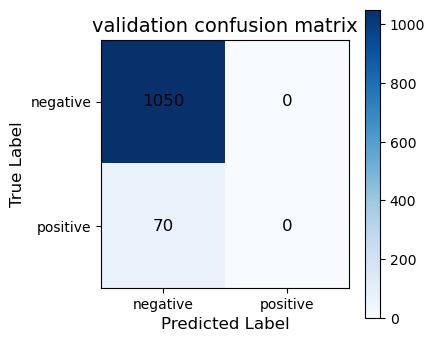

In [77]:
y_pred_probs = model1.predict(X_val1)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert to 0 or 1

# Compute confusion matrix
cm = confusion_matrix(y_val1, y_pred)

# Print classification report
print("Classification Report:\n", classification_report(y_val1, y_pred))
plot_confusion_matrix_alternative(y_val1, y_pred, ["negative", "positive"], title = 'validation confusion matrix')

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      1302
           1       0.00      0.00      0.00        98

    accuracy                           0.93      1400
   macro avg       0.47      0.50      0.48      1400
weighted avg       0.86      0.93      0.90      1400



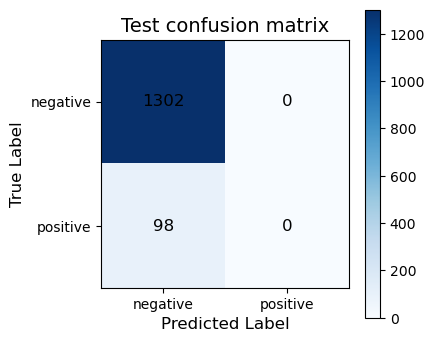

In [78]:
y_pred_probs = model1.predict(X_test_data)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert to 0 or 1

# Compute confusion matrix
cm = confusion_matrix(y_test_data, y_pred)

# Print classification report
print("Classification Report:\n", classification_report(y_test_data, y_pred))
plot_confusion_matrix_alternative(y_test_data, y_pred, ["negative", "positive"], title = "Test confusion matrix")

In [79]:
model2 = Sequential([
    SimpleRNN(25, input_shape=(1, 200), return_sequences=False),  # 1 hidden layer
    Dense(1, activation='sigmoid')  # Binary output (positive/negative)
])

# Compile model
model2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


In [80]:
from imblearn.over_sampling import RandomOverSampler

# Reshape X_train1 from (samples, 50, 200) → (samples, 50*200)
X_train1_reshaped = X_train1.reshape(X_train1.shape[0], -1)

# Apply oversampling
ros = RandomOverSampler(sampling_strategy="auto", random_state=42)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train1_reshaped, y_train1)

# Reshape back to (samples, 50, 200) for RNN input
X_train_balanced = X_train_balanced.reshape(-1, 50, 200)

# Train model on balanced dataset
model2.fit(X_train_balanced, y_train_balanced, epochs=5, batch_size=10, validation_data=(X_val1, y_val1))

Epoch 1/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7137 - loss: 0.5391 - val_accuracy: 0.8902 - val_loss: 0.3194
Epoch 2/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8840 - loss: 0.3175 - val_accuracy: 0.8982 - val_loss: 0.3002
Epoch 3/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9225 - loss: 0.2268 - val_accuracy: 0.8848 - val_loss: 0.3205
Epoch 4/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9286 - loss: 0.2109 - val_accuracy: 0.8848 - val_loss: 0.3380
Epoch 5/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9509 - loss: 0.1451 - val_accuracy: 0.9268 - val_loss: 0.2456


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      1050
           1       0.44      0.61      0.51        70

    accuracy                           0.93      1120
   macro avg       0.71      0.78      0.74      1120
weighted avg       0.94      0.93      0.93      1120



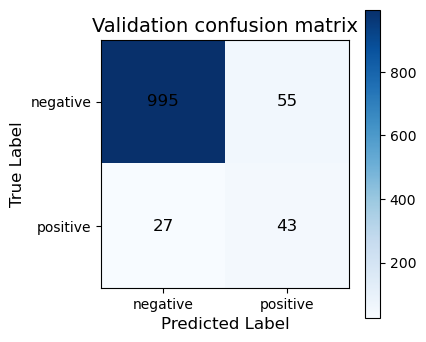

In [83]:
y_pred_probs = model2.predict(X_val1)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert to 0 or 1

# Compute confusion matrix
cm = confusion_matrix(y_val1, y_pred)

# Print classification report
print("Classification Report:\n", classification_report(y_val1, y_pred))
plot_confusion_matrix_alternative(y_val1, y_pred, ["negative", "positive"], title = "Validation confusion matrix")

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96      1302
           1       0.44      0.61      0.51        98

    accuracy                           0.92      1400
   macro avg       0.71      0.78      0.73      1400
weighted avg       0.93      0.92      0.92      1400



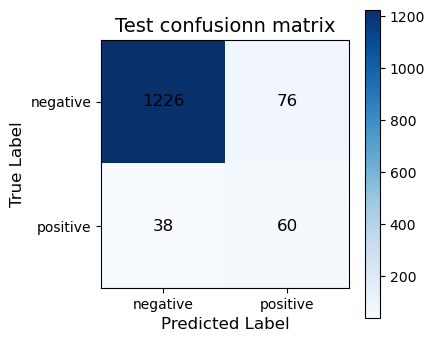

In [84]:
y_pred_probs = model2.predict(X_test_data)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert to 0 or 1

# Compute confusion matrix
cm = confusion_matrix(y_test_data, y_pred)

# Print classification report
print("Classification Report:\n", classification_report(y_test_data, y_pred))
plot_confusion_matrix_alternative(y_test_data, y_pred, ["negative", "positive"], title = 'Test confusionn matrix')


In [72]:
model3 = Sequential([
    SimpleRNN(25, input_shape=(1, 200), return_sequences=False),  # 1 hidden layer
    Dense(1, activation='sigmoid')  # Binary output (positive/negative)
])

# Compile model
model3.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


In [73]:
from imblearn.over_sampling import RandomOverSampler

# Reshape X_train1 from (samples, 50, 200) → (samples, 50*200)
X_train1_reshaped = X_train1.reshape(X_train1.shape[0], -1)  # (5600, 10000)

# Apply oversampling
ros = RandomOverSampler(sampling_strategy=0.5, random_state=42)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train1_reshaped, y_train1)

# Reshape back to (samples, 50, 200) for RNN input
X_train_balanced = X_train_balanced.reshape(-1, 50, 200)

# Train model on balanced dataset
model3.fit(X_train_balanced, y_train_balanced, epochs=5, batch_size=10, validation_data=(X_val1, y_val1))

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7354 - loss: 0.5452 - val_accuracy: 0.9196 - val_loss: 0.2771
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8335 - loss: 0.3931 - val_accuracy: 0.9277 - val_loss: 0.2277
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8610 - loss: 0.3368 - val_accuracy: 0.9018 - val_loss: 0.2568
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8729 - loss: 0.3102 - val_accuracy: 0.8902 - val_loss: 0.2627
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8726 - loss: 0.3177 - val_accuracy: 0.9009 - val_loss: 0.2638


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      1050
           1       0.27      0.36      0.31        70

    accuracy                           0.90      1120
   macro avg       0.62      0.65      0.63      1120
weighted avg       0.91      0.90      0.91      1120



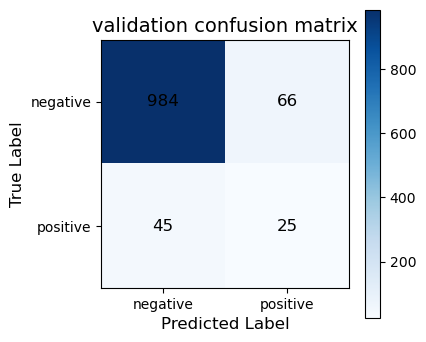

In [86]:
y_pred_probs = model3.predict(X_val1)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert to 0 or 1

# Compute confusion matrix
cm = confusion_matrix(y_val1, y_pred)

# Print classification report
print("Classification Report:\n", classification_report(y_val1, y_pred))
plot_confusion_matrix_alternative(y_val1, y_pred, ["negative", "positive"], title = "validation confusion matrix")

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      1302
           1       0.35      0.42      0.38        98

    accuracy                           0.91      1400
   macro avg       0.65      0.68      0.67      1400
weighted avg       0.91      0.91      0.91      1400



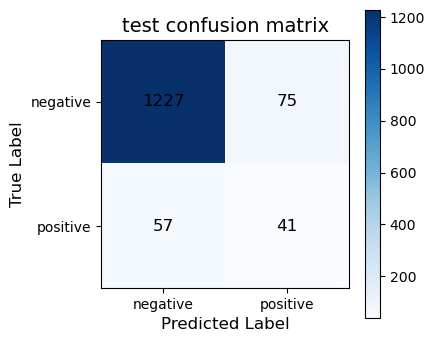

In [85]:
y_pred_probs = model3.predict(X_test_data)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert to 0 or 1

# Compute confusion matrix
cm = confusion_matrix(y_test_data, y_pred)

# Print classification report
print("Classification Report:\n", classification_report(y_test_data, y_pred))

# Plot confusion matrix
plot_confusion_matrix_alternative(y_test_data, y_pred, ["negative", "positive"], title = "test confusion matrix")
